In [1]:
import numpy as np
from scipy import special
import random
import matplotlib.pyplot as plt

In [2]:
N_STATES = 10
TAU_LIMIT = 9

In [3]:
class Environment1:
    def __init__(self) -> None:
        self.k = 1
        self.sigma2 = 0.6613
        self.zeta = 45
        self.L = 1
        self.P_bar = .6613
        self.h = np.array([self.P_bar])
        self.A = np.array([1.2])
        self.channel_states = (np.array(range(10)) + 1) * .2
        self.eta = np.array([[.91,.09,  0,  0,  0,  0,  0,  0,  0,  0],
                             [ .9, .1,  0,  0,  0,  0,  0,  0,  0,  0],
                             [ .8,.12,.08,  0,  0,  0,  0,  0,  0,  0],
                             [ .7,.11,.11,.08,  0,  0,  0,  0,  0,  0],
                             [ .6,.11, .1, .1,.09,  0,  0,  0,  0,  0],
                             [ .5,.18, .1,.08,.07,.07,  0,  0,  0,  0],
                             [ .4,.28, .1,.06,.05,.06,.05,  0,  0,  0],
                             [ .3, .1, .1, .1,.16,.14,.09,.01,  0,  0],
                             [ .2,.11, .1, .1, .1,.05,.09,.13,.12,  0],
                             [ .1, .1, .1, .1, .1, .1, .1, .1, .1,  0]])
        
    
    def robot_reward(self, state, action):
        '''Gives the one-step reward for a given state-action pair'''
        tau = int(state / N_STATES)

        # If tau is 0, error is just the single transmission error
        if tau == 0:
            self.h = self.P_bar
        else:
            self.h = self.A**2 * self.h
            
        # The following just has to do with ugly implementation
        if type(self.h) == float:
            return self.h + action * self.k * self.zeta
        if  self.h.size == 1:
            return self.h[0] + action * self.k * self.zeta
        return np.trace(self.h) + action * self.k * self.zeta
    
    def f(self, SNR):
        '''This is an internal function to do with the probability of recieving properly (SNR stuff)'''
        two_F = special.erf(SNR) / np.sqrt(2)
        return (1 - two_F) ** self.L
    
    def new_state(self, state, action):
        '''This generates a new state given the old state-action pair'''
        # States are saved as: (tau * N_STATES) + h

        # Unwrapping state into tau and h
        tau = int(state / N_STATES)
        h = state % N_STATES

        # Generating a new h based on eta
        new_h = random.choices(range(N_STATES), weights=self.eta[h,:N_STATES], k=1)[0]

        # Assuming a failure of reception
        new_tau = tau + 1

        if action != 0:
            # Reception can only happen if transmission, depending on probability p_j that depends on the SNR
            SNR = self.channel_states[h] * self.zeta / self.sigma2
            p_j = self.f(SNR)

            # Making tau 0 with that probability
            r = random.random()
            if r > p_j:
                new_tau = 0
        
        # Limitting tau to the TAU_LIMIT
        new_tau = new_tau % (TAU_LIMIT+1)

        # Wrapping the state (new_h, new_tau) and returning an int
        return int((new_tau * N_STATES) + new_h)

    def generate_episode(self, policy, length_of_episode, starting_state=random.randint(0,N_STATES)):
        episode = []
        curr_state = starting_state
        for k in range(length_of_episode):
            a = policy(curr_state)
            r = self.robot_reward(curr_state, a)
            episode.append((curr_state, a, r))
            curr_state = self.new_state(curr_state, a)
        return episode
    
env = Environment1()
print(env.robot_reward(0,0))

print(env.new_state(0, 0))
print(env.new_state(0, 0))
print(env.new_state(0, 0))

0.6613
10
10
10


In [4]:
class Greedy:
    '''This Greedy is not altruistic at all, i.e., alpha = 0'''
    def __init__(self, n_states, n_actions, env) -> None:
        self.values = np.abs(np.random.randn(n_states, n_actions))
        self.counts = np.zeros((n_states, n_actions))

        self.env = env
    
    def action_to_take(self, state):
        '''Decides the chosen arm, based on the estimate values(saved)'''

        # Unwrapping the state
        tau = int(state/N_STATES)
        h = state % N_STATES

        # If tau is too high, and channel gain allows good SNR, we transmit
        if tau >= 5 and h > 3:
            return 1
        
        # If we don't know what's higher value based on estimated values, random choice
        if self.values[state, 0] == self.values[state, 1]:
            r = random.random()
            if r > .5:
                return 1
            else:
                return 0
        
        # Else, return the best
        return np.argmax(self.values[state, :])
    
    def train_single_state(self, state):
        '''Trains the robot to update its estimates'''
        # Estimates the action to be taken
        a = self.action_to_take(state)

        # Checks the reward
        r = self.env.robot_reward(state, a)

        # Updates the reward as the average of observed rewards
        temp = self.values[state, a] * self.counts[state, a] + r
        self.counts[state, a] += 1
        self.values[state, a] = temp / self.counts[state, a]

# Create an object of this policy
p1 = Greedy(N_STATES*(TAU_LIMIT+1), 2, env)

# Training it
s = 2
count = 0
while 1:
    old = np.copy(p1.values)
    p1.train_single_state(s)

    s = env.new_state(s, p1.action_to_take(s))
    n = np.copy(p1.values)

    count += 1

    if np.linalg.norm(old-n) < 1e-9 and count > 100000:
        print("Count:", count)
        break

policy = np.array([[p1.action_to_take(N_STATES*i + j) for j in range(N_STATES)] for i in range(TAU_LIMIT+1) ])
print(policy)


Count: 100001
[[1 1 1 1 0 1 1 1 0 1]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 1 1 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 0]
 [1 0 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1]]


(array([608., 167.,  63.,  63.,  59.,  26.,  10.,   2.,   1.,   1.]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

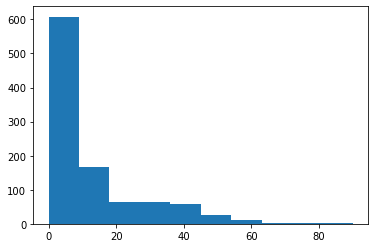

In [5]:
class Environment2:
    ''''This was developed for Part B of the paper's simulations section'''
    def __init__(self) -> None:
        self.k = 1
        self.sigma2 = 0.6613
        self.zeta = 45
        self.L = 1
        self.P_bar = .6613
        self.h = np.array([self.P_bar])
        self.A = np.array([1.2])
        self.channel_states = (np.array(range(10)) + 1) * .2
        self.eta = np.array([[.91,.09,  0,  0,  0,  0,  0,  0,  0,  0],
                             [ .9, .1,  0,  0,  0,  0,  0,  0,  0,  0],
                             [ .8,.12,.08,  0,  0,  0,  0,  0,  0,  0],
                             [ .7,.11,.11,.08,  0,  0,  0,  0,  0,  0],
                             [ .6,.11, .1, .1,.09,  0,  0,  0,  0,  0],
                             [ .5,.18, .1,.08,.07,.07,  0,  0,  0,  0],
                             [ .4,.28, .1,.06,.05,.06,.05,  0,  0,  0],
                             [ .3, .1, .1, .1,.16,.14,.09,.01,  0,  0],
                             [ .2,.11, .1, .1, .1,.05,.09,.13,.12,  0],
                             [ .1, .1, .1, .1, .1, .1, .1, .1, .1,  0]])
        
    
    def robot_reward(self, state, action):
        tau = int(state / N_STATES)

        # If tau is 0, error is just the single transmission error
        if tau == 0:
            self.h = self.P_bar
        else:
            self.h = self.A**2 * self.h

        # The following just has to do with ugly implementation
        if type(self.h) == float:
            return self.h + action * self.k * self.zeta
        if  self.h.size == 1:
            return self.h[0] + action * self.k * self.zeta
        return np.trace(self.h) + action * self.k * self.zeta
    
    def f(self, SNR):
        '''This is an internal function to do with the probability of recieving properly (SNR stuff)'''
        two_F = special.erf(SNR) / np.sqrt(2)
        return (1 - two_F) ** self.L
    
    def new_state(self, state, action):
        '''This generates a new state given the old state-action pair'''
        tau = int(state / N_STATES)
        h = state % N_STATES

        new_h = random.choices(range(N_STATES), weights=self.eta[h,:N_STATES], k=1)[0]

        new_tau = tau + 1

        if action != 0:
            SNR = self.channel_states[h] * self.zeta / self.sigma2
            p_j = self.f(SNR)
            r = random.random()
            if r > p_j:
                new_tau = 0
        
        new_tau = new_tau % (TAU_LIMIT+1)
        return int((new_tau * N_STATES) + new_h)
    
    def generate_episode(self, policy, length_of_episode, starting_state=random.randint(0,N_STATES)):
        '''To generate an episode of length 'length_of_episode', using policy 'policy' '''
        episode = []
        curr_state = starting_state
        for k in range(length_of_episode):
            a = policy(curr_state)
            r = self.robot_reward(curr_state, a)
            episode.append((curr_state, a, r))
            curr_state = self.new_state(curr_state, a)
        return episode


env2 = Environment1()

# To test the functions
# print(env2.robot_reward(0,0))
# print(env2.new_state(0, 0))

# Generate an episode to understand probabilities, etc.
episode = (env2.generate_episode(p1.action_to_take, 1000))

# Unwrapping to just the states
states = []
for i in range(len(episode)):
    s, _, _ = episode[i]
    states.append(s)

# Drawing a histogram of the states, to understand which states are transitioned to more often
plt.hist(states)

In [6]:
class Greedy_per_episode:
    def __init__(self, n_states, n_actions, env) -> None:
        self.values = np.zeros((n_states, n_actions))
        self.counts = np.zeros((n_states, n_actions))
        self.alpha = 0.6

        self.env = env
    
    def action_to_take(self, state):
        tau = int(state/N_STATES)
        h = state % N_STATES
        if tau >= 5 and h > 3:
            return 1
        
        if self.values[state, 0] == self.values[state, 1]:
            r = random.random()
            if r > .5:
                return 1
            else:
                return 0

        return np.argmax(self.values[state, :])
    
    def policy(self):
        return np.array([[self.action_to_take(N_STATES*i + j) for i in range(TAU_LIMIT+1)] for j in range(N_STATES)])
    
    def train_episode(self, episode):
        curr_state_idx = len(episode) - 1
        curr_val = 0
        
        while curr_state_idx >= 0:
            s , a, r = episode[curr_state_idx]
            curr_state_idx -= 1
            tau = int(s/N_STATES)
            h = s % N_STATES
            if tau >= 5 and h > 3:
                continue
            curr_val = (curr_val*self.alpha) + r
            temp = self.values[s,a] * self.counts[s,a]
            self.counts[s, a] += 1

            self.values[s,a] = (temp + curr_val) / self.counts[s,a]


p2 = Greedy_per_episode(n_states=N_STATES*(TAU_LIMIT+1), n_actions=2, env=env2)

ep = env2.generate_episode(p2.action_to_take, 100000)
p2.train_episode(ep)

print("Trained one step!")

print(p2.policy())

# print(np.reshape(np.floor(p2.values), (2, 10,10)))

Trained one step!
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 0 0 1 1 1]
 [1 1 1 1 0 0 1 0 0 0]
 [0 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 1 1 1 1 1]
 [0 0 1 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 1 1 1]
 [1 1 0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1]]


In [7]:
for i in range(10):
    old_values = np.copy(p2.values)
    ep = env2.generate_episode(p2.action_to_take, 10000)
    p2.train_episode(ep)
    new_values = np.copy(p2.values)
    if np.linalg.norm(old_values - new_values) < 1e-4:
        print(i)
        break
print(p2.policy())

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 0 1 0 0 0]
 [0 0 1 0 0 1 1 1 0 1]
 [0 1 1 0 1 1 1 1 1 1]
 [0 1 0 1 1 1 1 1 1 1]
 [1 0 1 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1]
 [0 1 1 0 0 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1]]


In [8]:
class Greedy_per_episode_v2:
    '''This is my attempt at P2_greedy'''
    def __init__(self, n_states, n_actions, env) -> None:
        self.values = np.zeros((n_states, n_actions))
        self.counts = np.zeros((n_states, n_actions))
        self.alpha = 0.6

        self.env = env
    
    def action_to_take(self, state):
        '''Defines the policy'''

        # Unwrapping the state
        tau = int(state/N_STATES)
        h = state % N_STATES

        # Some threshold I don't understand yet
        if tau >= 5:
            return 1
        
        # If we have no "best option", choose random with probability 0.5
        if self.values[state, 0] == self.values[state, 1]:
            r = random.random()
            if r > .5:
                return 1
            else:
                return 0
        
        # Otherwise, all good. Return the max
        return np.argmax(self.values[state, :])
    
    def policy(self):
        '''To get a printable form of the policy (Refer Fig. 2 of Original Paper.pdf)'''
        return np.array([[self.action_to_take(N_STATES*i + j) for i in range(TAU_LIMIT+1)] for j in range(N_STATES)])
        
    def train_episode(self, episode):
        '''This trains on episodes as below, Every Visit update, and can be used for ON or OFF policy'''
        curr_state_idx = len(episode) - 1
        curr_val = 0
        
        # Starting from the back so we don't have to loop through the rest of the episode for each state
        while curr_state_idx >= 0:
            # Unwrapping the episode into state, action, reward
            s, a, r = episode[curr_state_idx]
            # Decrementing the index of the episode step
            curr_state_idx -= 1

            # Unwrapping the state to get tau alone
            tau = int(s/N_STATES)

            # The weird, ununderstood threshold
            if tau >= 5:
                continue

            # Update the current value
            curr_val = (curr_val*self.alpha) + r

            # Update the policy's estimate
            temp = self.values[s,a] * self.counts[s,a]
            self.counts[s, a] += 1
            self.values[s,a] = (temp + curr_val) / self.counts[s,a]


p3 = Greedy_per_episode_v2(n_states=100, n_actions=2, env=env2)

# print(np.reshape((p2.values), (2, 10,10)))
print(p3.policy())

ep = env2.generate_episode(p2.action_to_take, 100000)
p3.train_episode(ep)

print("Trained a single step!")

# print(p1.values)
print(p3.policy())

# print(np.reshape(np.floor(p2.values), (2, 10,10)))

[[0 1 1 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 0 1 1 1 1 1]
 [0 1 0 0 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [0 0 1 1 0 1 1 1 1 1]
 [1 1 0 0 0 1 1 1 1 1]
 [1 0 1 1 0 1 1 1 1 1]]
Trained a single step!
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 1 1 1]
 [1 1 0 0 0 1 1 1 1 1]
 [0 0 1 0 1 1 1 1 1 1]
 [0 0 0 1 0 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1]
 [0 1 0 0 0 1 1 1 1 1]
 [0 1 0 0 1 1 1 1 1 1]
 [1 1 0 1 0 1 1 1 1 1]]


In [9]:
# Training over multiple episodes
for i in range(500):
    # For convergence testing, save the original values
    old_values = np.copy(p3.values)

    # Generate an episode
    ep = env2.generate_episode(p3.action_to_take, 10000)

    # Train based on the generated episode
    p3.train_episode(ep)

    # For convergence testing, save the new values
    new_values = np.copy(p3.values)

    # If the values have converged, probably no point in training more
    if np.linalg.norm(old_values - new_values) < 1e-4:
        print(i)
        break

# Printing the trained policy
print(p3.policy())

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 1 0 1 0 1 1 1 1 1]
 [1 0 0 1 0 1 1 1 1 1]
 [1 1 1 0 0 1 1 1 1 1]
 [1 1 0 1 0 1 1 1 1 1]
 [0 0 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


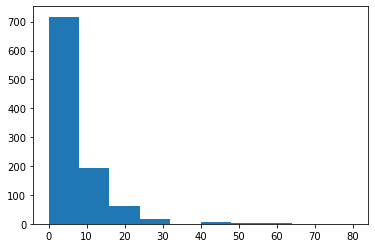

In [11]:
# Generate an episode to understand probabilities, etc.
episode = (env2.generate_episode(p3.action_to_take, 1000))

# Unwrapping to just the states
states = []
for i in range(len(episode)):
    s, _, _ = episode[i]
    states.append(s)

# Drawing a histogram of the states, to understand which states are transitioned to more often
plt.hist(states)
plt.show()